In [50]:
import glob 
import os
import numpy as np
import rasterio
from rasterio.mask import mask
import matplotlib.pyplot as plt
from shapely import geometry
from scipy.signal import fftconvolve
from scipy.ndimage import label
from scipy.ndimage.morphology import binary_fill_holes
from skimage.feature import canny
from skimage.morphology import dilation, reconstruction
from skimage.exposure import equalize_adapthist
from skimage.transform import resize
from skimage import segmentation, feature, future
from sklearn.ensemble import RandomForestClassifier

In [51]:
def transform_imagery(file,dst_crs):
    with rasterio.open(file) as src:
        transform, width, height = calculate_default_transform(
            src.crs, dst_crs, src.width, src.height, *src.bounds)
        kwargs = src.meta.copy()
        kwargs.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height
        })
        ext = file[-4:]
        with rasterio.open(file.split(ext)[0] + "_" + dst_crs + ext, 'w', **kwargs) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),
                    destination=rasterio.band(dst, i),
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest)
                
def clip(raster,bounds):
    # raster.bounds returns left, bottom, right, top
    # below is left, right, bottom, top
    clip_mask = geometry.Polygon([(bounds[0],bounds[2]),
                            (bounds[0],bounds[3]),
                            (bounds[1],bounds[3]),
                            (bounds[1],bounds[2]),
                            (bounds[0],bounds[2])])
    out_raster, out_transform = mask(raster, shapes=[clip_mask], crop=True)
    return out_raster
    
def align_images(image_1,image_2):
    
    # normalize inputs
    norm_1 = image_1/np.max(image_1)
    norm_2 = image_2/np.max(image_2)

    # demean inputs
    demean_norm_1 = norm_1 - np.mean(norm_1)
    demean_norm_2 = norm_2 - np.mean(norm_2)
    
    # compute autocorrelation of first input
    auto_corr = fftconvolve(demean_norm_1, demean_norm_1[::-1,::-1], mode='same')
    y_auto,x_auto = np.unravel_index(auto_corr.argmax(), auto_corr.shape)

    # compute correlation between each in put
    corr = fftconvolve(demean_norm_1, demean_norm_2[::-1,::-1], mode='same')
    y,x = np.unravel_index(corr.argmax(), corr.shape)

    # compute shift values
    y_shift = y-y_auto
    x_shift = x-x_auto
    
    return x_shift,y_shift


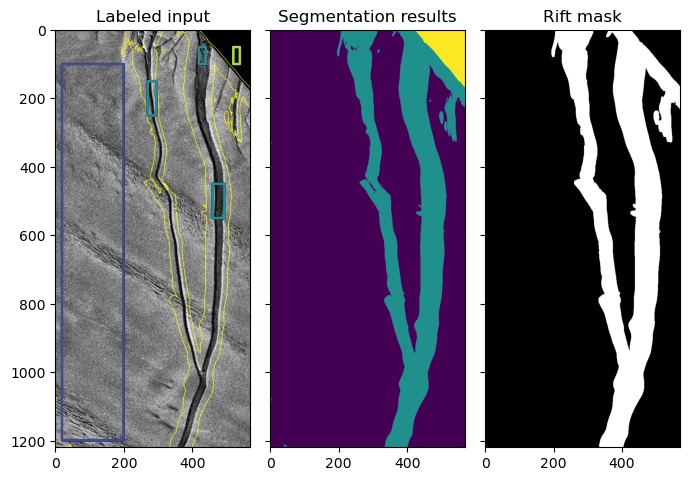

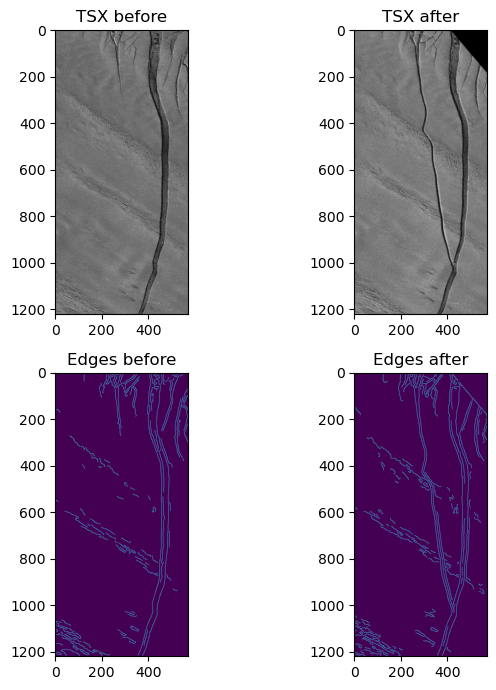

In [52]:
'''

Play around with image processing to isolate fracture (this cell is now deprecated)

'''

# transform all TerraSAR-X data to epsg:3245
TSX_path = '../../data/TSX/'
# files = glob.glob(TSX_path + '*/TSX-1.SAR.L1B/*/IMAGEDATA/*')
# files = [f for f in files if "epsg:3245" not in f] 
# for file in files:
#     transform_imagery(file,'epsg:3245')

# set TerraSAR-X data file path
tsx_scenes = ['dims_op_oc_dfd2_689344819_4','dims_op_oc_dfd2_689344819_5']

# read tsx scene before fracture
directory = os.listdir(TSX_path + tsx_scenes[0] + '/TSX-1.SAR.L1B/')[0]
file_path = TSX_path + tsx_scenes[0]+'/TSX-1.SAR.L1B/'+ directory + '/IMAGEDATA/'
before_scene = rasterio.open(glob.glob(file_path + '*epsg:3245.tif')[0])

# read tsx scene after fracture
directory = os.listdir(TSX_path + tsx_scenes[1] + '/TSX-1.SAR.L1B/')[0]
file_path = TSX_path +tsx_scenes[1]+'/TSX-1.SAR.L1B/'+ directory + '/IMAGEDATA/'
after_scene = rasterio.open(glob.glob(file_path + '*epsg:3245.tif')[0])

# clip a small region of rift to use for alignment
bounds = [-65500, -65000, 1719500, 1720500]
before_clip = clip(before_scene,bounds)
after_clip = clip(after_scene,bounds)

# cross-correlate data near the rift tip, which doesn't change position between scenes
x_shift,y_shift = align_images(before_clip[0],after_clip[0])

# clip region of images that include new fracture
bounds = [-69700, -60150, 1722900, 1743200]
before_clip = clip(before_scene,bounds)
after_clip = clip(after_scene,bounds)

# align the images using computed shifts
before_shifted = before_clip[0,y_shift:,x_shift:]
after_shifted = after_clip[0,:before_shifted.shape[0],:before_shifted.shape[1]]

# downsample to speed up image processing
before_small = resize(before_shifted, np.asarray(before_shifted.shape)//10)
after_small = resize(after_shifted, np.asarray(after_shifted.shape)//10)  

# make a rift mask using a supervised random forest segmentation alogrithm
training_labels = np.zeros(after_small.shape[:2], dtype=np.uint8)
training_labels[100:1200, 20:200] = 1
training_labels[450:550, 460:495] = 2
training_labels[50:100, 420:440] = 2
training_labels[150:250, 270:295] = 2
training_labels[50:100, 520:540] = 3
features = feature.multiscale_basic_features(after_small)
classifier = RandomForestClassifier(n_estimators=50, n_jobs=-1)
classifier = future.fit_segmenter(training_labels, features, classifier)
segments = future.predict_segmenter(features, classifier)

# extract segment containing the rift and dilate so there's some buffer
rift_mask = np.array([segments == 2]).astype('uint8')
footprint = np.ones((5,5))
dilated_rift_mask = dilation(rift_mask[0],footprint=footprint)

# fill any holes in mask
filled_rift_mask = binary_fill_holes(dilated_rift_mask)

# extract just the rift mask, which is the largest non-background segment
labels = label(filled_rift_mask)
label_numbers = [np.sum(labels[0]==num) for num in range(labels[1])]
label_numbers[0] = np.nan
rift_label = np.nanargmax(label_numbers)
rift_mask = [labels[0] == rift_label][0]

# equalize before and after images
before_equalized = equalize_adapthist(before_small)
after_equalized = equalize_adapthist(after_small)

# make a plot of the segmentation results and dilated rift mask
fig, ax = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(7, 7))
ax[0].imshow(segmentation.mark_boundaries(after_equalized, segments, mode='thick'))
ax[0].contour(training_labels)
ax[0].set_title('Labeled input')
ax[1].imshow(segments)
ax[1].set_title('Segmentation results')
ax[2].imshow(rift_mask,cmap='gray')
ax[2].set_title('Rift mask')
fig.tight_layout()

# extract edges from before and after images
before_edges = canny(before_equalized , sigma=3)
after_edges = canny(after_equalized , sigma=3)

# plot edges
fig,ax = plt.subplots(2,2,figsize=(7,7))
ax[0,0].imshow(before_small,cmap='gray')
ax[0,1].imshow(after_small,cmap='gray')
ax[1,0].imshow(before_edges)
ax[1,1].imshow(after_edges)
ax[0,0].set_title('TSX before')
ax[0,1].set_title('TSX after')
ax[1,0].set_title('Edges before')
ax[1,1].set_title('Edges after')
fig.tight_layout()